
[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Gefundene Matches: 249 Songs
Random Forest Test Accuracy: 0.62
Random Forest Cross Validation Scores: [0.65       0.5        0.65       0.7        0.56410256]
Random Forest Mean CV Accuracy: 0.6128205128205128
✅ Random Forest Modell gespeichert in grammy_rf_model.pkl
Logistic Regression Test Accuracy: 0.64
Logistic Regression Cross Validation Scores: [0.55       0.6        0.65       0.575      0.43589744]
Logistic Regression Mean CV Accuracy: 0.5621794871794872
=== 📊 Random Forest - Classification Report ===
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        21
           1       0.68      0.66      0.67        29

    accuracy                           0.62        50
   macro avg       0.61      0.61      0.61        50
weighted avg       0.62 

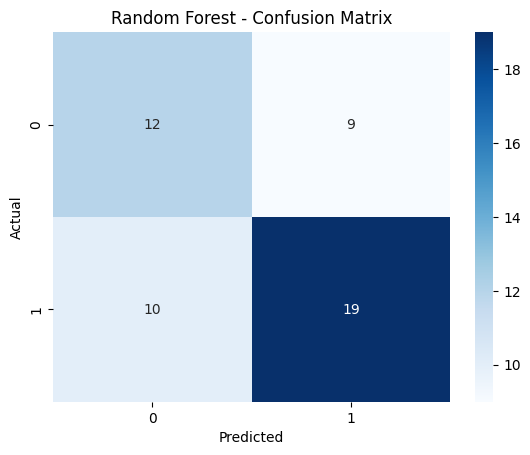

=== 📊 Logistic Regression - Classification Report ===
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        21
           1       0.65      0.83      0.73        29

    accuracy                           0.64        50
   macro avg       0.63      0.60      0.60        50
weighted avg       0.63      0.64      0.62        50



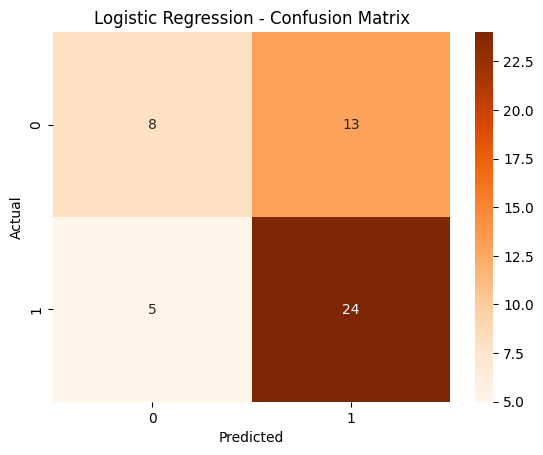

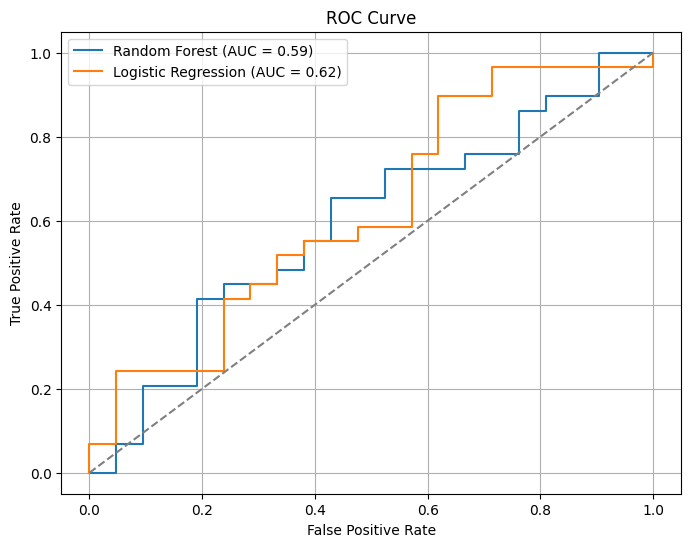

,Model,Test Accuracy,Mean CV Accuracy,AUC,F1-Score
0,Random Forest,0.62,0.612821,0.594417,0.666667
1,Logistic Regression,0.64,0.562179,0.620690,0.727273


✅ Logistic Regression Modell gespeichert in grammy_lr_model.pkl
🌟 Training abgeschlossen: Zwei Modelle gespeichert!
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://0d114a97a6971274e6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
# grammy_model.ipynb (Endversion mit Grammy-Status der Top-Songs)

%pip install gradio

import pandas as pd
import numpy as np
import pickle
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score
)

# 1. Daten laden
grammy_df = pd.read_csv("data/grammy_winners.csv")
spotify_df = pd.read_csv("data/Spotify-2000.csv")

# 2. Vorbereitung: Namen vereinheitlichen
grammy_df['song_or_album'] = grammy_df['song_or_album'].str.lower().str.strip()
grammy_df['artist'] = grammy_df['artist'].str.lower().str.strip()
spotify_df['Title'] = spotify_df['Title'].str.lower().str.strip()
spotify_df['Artist'] = spotify_df['Artist'].str.lower().str.strip()

# 3. Merge auf Songtitel und Künstler
merged = pd.merge(
    grammy_df,
    spotify_df,
    left_on=['song_or_album', 'artist'],
    right_on=['Title', 'Artist'],
    how='inner'
)

print(f"Gefundene Matches: {merged.shape[0]} Songs")

# 4. Feature-Engineering
selected_features = ['Danceability', 'Energy', 'Valence', 'Beats Per Minute (BPM)']
merged = merged[selected_features + ['winner']]

X = merged[selected_features]
y = merged['winner'].astype(int)

# 5. Vorbereitung: Skalierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ---
# 6. Modell 1: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_test_accuracy = rf_model.score(X_test, y_test)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print("Random Forest Test Accuracy:", rf_test_accuracy)
print("Random Forest Cross Validation Scores:", rf_cv_scores)
print("Random Forest Mean CV Accuracy:", np.mean(rf_cv_scores))

# Modell speichern
rf_bundle = {
    "model": rf_model,
    "feature_names": selected_features,
    "scaler": scaler
}

with open("grammy_rf_model.pkl", "wb") as f:
    pickle.dump(rf_bundle, f)

print("✅ Random Forest Modell gespeichert in grammy_rf_model.pkl")

# ---
# 7. Modell 2: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

lr_test_accuracy = lr_model.score(X_test, y_test)
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5)

print("Logistic Regression Test Accuracy:", lr_test_accuracy)
print("Logistic Regression Cross Validation Scores:", lr_cv_scores)
print("Logistic Regression Mean CV Accuracy:", np.mean(lr_cv_scores))

# 8. 🔍 Performanceanalyse & Visualisierung

# Vorhersagen
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Klassifikationsberichte
print("=== 📊 Random Forest - Classification Report ===")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("=== 📊 Logistic Regression - Classification Report ===")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-Kurve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_rf = roc_auc_score(y_test, y_proba_rf)
auc_lr = roc_auc_score(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Zusammenfassung als Tabelle
results_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression"],
    "Test Accuracy": [rf_test_accuracy, lr_test_accuracy],
    "Mean CV Accuracy": [np.mean(rf_cv_scores), np.mean(lr_cv_scores)],
    "AUC": [auc_rf, auc_lr],
    "F1-Score": [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_lr)]
})

display(results_df)

# Modell speichern
lr_bundle = {
    "model": lr_model,
    "feature_names": selected_features,
    "scaler": scaler
}

with open("grammy_lr_model.pkl", "wb") as f:
    pickle.dump(lr_bundle, f)

print("✅ Logistic Regression Modell gespeichert in grammy_lr_model.pkl")

print("🌟 Training abgeschlossen: Zwei Modelle gespeichert!")

# ---
# 8. Modelle laden für Gradio

with open("grammy_rf_model.pkl", "rb") as f_rf:
    rf_bundle = pickle.load(f_rf)

with open("grammy_lr_model.pkl", "rb") as f_lr:
    lr_bundle = pickle.load(f_lr)

models = {
    "Random Forest": rf_bundle,
    "Logistic Regression": lr_bundle
}

# Spotify-Daten laden für Song-Vergleich
spotify_features_df = spotify_df[['Title', 'Artist', 'Danceability', 'Energy', 'Valence', 'Beats Per Minute (BPM)']].dropna()

# Vorhersagefunktion definieren mit Top-Songs und Grammy-Status
def predict_grammy(model_choice, danceability, energy, valence, bpm):
    bundle = models[model_choice]
    model = bundle["model"]
    feature_names = bundle["feature_names"]
    scaler = bundle["scaler"]

    input_data = pd.DataFrame([[danceability, energy, valence, bpm]], columns=feature_names)
    input_scaled = scaler.transform(input_data)
    proba = model.predict_proba(input_scaled)[0][1]

    # Top ähnliche Songs berechnen
    spotify_features = spotify_features_df[feature_names]
    distances = cdist(input_data, spotify_features, metric='euclidean')[0]
    top_indices = np.argsort(distances)[:3]
    top_songs = spotify_features_df.iloc[top_indices][['Title', 'Artist']]

    # Grammy-Status der ähnlichen Songs überprüfen
    top_songs_list = []
    for idx, row in top_songs.iterrows():
        title = row['Title']
        artist = row['Artist']
        is_grammy = ((grammy_df['song_or_album'] == title) & (grammy_df['artist'] == artist)).any()
        status = "(Grammy Winner)" if is_grammy else "(No Grammy)"
        top_songs_list.append(f"- {title.title()} von {artist.title()} {status}")

    result = f"Modell: {model_choice}\nGewinnwahrscheinlichkeit: {proba * 100:.2f}%\n\nTop ähnliche Songs:\n" + "\n".join(top_songs_list)
    return result

# Gradio Interface aufbauen
demo = gr.Interface(
    fn=predict_grammy,
    inputs=[
        gr.Dropdown(choices=["Random Forest", "Logistic Regression"], label="Wähle ein Modell"),
        gr.Slider(0, 100, step=1, label="Danceability (0-100)"),
        gr.Slider(0, 100, step=1, label="Energy (0-100)"),
        gr.Slider(0, 100, step=1, label="Valence (0-100)"),
        gr.Number(label="Tempo (Beats Per Minute)")
    ],
    outputs="text",
    title="🌟 Grammy Winning Prediction",
    description="Prognostiziere mit verschiedenen ML-Modellen, ob ein Song eine hohe Grammy-Gewinnwahrscheinlichkeit hat und finde ähnliche Top-Songs mit Grammy-Status."
)

# App starten
demo.launch(share=True)

